### A3

In [302]:
import numpy as np
import tensorflow as tf

from collections import Counter

from utils import reduce_logsumexp
from utils import logsoftmax

import matplotlib.pyplot as plt
%matplotlib inline

### 1.1

1. You can implement the squared euclidean distance function between a B x D matrix X and a K x D matrix Y as
$(X-Y)^T(X-Y) = XX^T -2XY^T + YY^T$. This is equivalent to expanding the product of the differences.

2.

In [2]:
x_np = np.array([[1, 1], [2, 2]]).astype("float32")
x_np

array([[ 1.,  1.],
       [ 2.,  2.]], dtype=float32)

In [3]:
y_np = np.array([[1, 1], [2, 2], [3, 3]]).astype("float32")
y_np

array([[ 1.,  1.],
       [ 2.,  2.],
       [ 3.,  3.]], dtype=float32)

In [4]:
X = tf.Variable(x_np)

In [5]:
Y = tf.Variable(y_np)

In [6]:
def matDistance(X, Y):
    # X is N X D
    # Y is K x D
    
    assert X.get_shape()[1] == Y.get_shape()[1]
    
    Y_T = tf.transpose(Y)
    
    # Element-wise multiplication
    XX = tf.mul(X, X) 
    YY = tf.mul(Y_T, Y_T)
    
    # Sum XX along row, and YY along column
    XX = tf.reshape(tf.reduce_sum(XX, 1), [-1, 1]) # N x 1
    YY = tf.reshape(tf.reduce_sum(YY, 0), [1, -1]) # 1 x K
    XY = tf.mul(2.0, tf.matmul(X, Y_T))            # N x K
    
    return XX - XY + YY

In [78]:
dist = matDistance(X, Y)

In [81]:
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    v = sess.run(dist)    
    print v # will show you your variable.

[[ 0.  2.  8.]
 [ 2.  0.  2.]]


### 1.2

1. The loss function is not convex. The algorithm is guaranteed to converge, but may converge to a local minima, not a global one. Mathematically, the loss function is not convex because it is not defined on a convex set. Intuitively, we can see this in a trivial example, where the solution is non-unique. Consider the datapoints in the cartesian plane {(0, 0), (0, 2), (2, 2), (2, 0)}. For K = 2, we have a local minima for $\mu$ = {(0, 1), (2, 1)} and another for $\mu$ = {(1, 0), (1, 2)}. The existence of multiple local minima imples the loss function is not convex.

In [537]:
data = np.load('data2D.npy')

In [538]:
data.shape

(10000, 2)

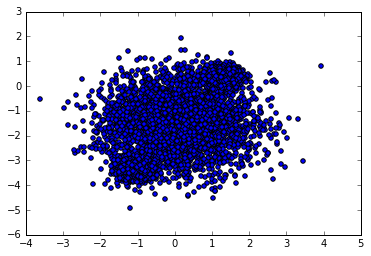

In [539]:
plt.scatter(data.T[0], data.T[1])

In [394]:
def mu_var(shape, stddev=0.25):
  initial = tf.truncated_normal(shape, stddev)
  return tf.Variable(initial)

In [176]:
def k_means(K, data, learning_rate, num_epochs, validation_start):
    
    training_data   = data[:validation_start]
    validation_data = data[validation_start:]
    
    N = training_data.shape[0]
    D = training_data.shape[1]
    
    X = tf.placeholder("float", shape=(None, D)) # N x D
    mu = mu_var((K, D)) # K x D
    
    dist = matDistance(X, mu) # N x K
    
    # Take the minimum across all K
    min_dist = tf.reduce_min(dist, 1) # N x 1
    
    # Sum across all training examples
    L = tf.reduce_sum(min_dist, 0)
    
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train_op = optimizer.minimize(L)
    
    # Determine cluster assignments
    assg = tf.argmin(dist, 1)
    
    init = tf.initialize_all_variables()
    
    loss_results = np.zeros(num_epochs)
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            loss, _ = sess.run([L, train_op], feed_dict={X: training_data})
            loss_results[epoch] = loss
            
        cluster_assignments = sess.run(assg, feed_dict={X: training_data})
        validation_loss     = sess.run(L,    feed_dict={X: validation_data})
        
    return loss_results, cluster_assignments, validation_loss

In [99]:
def plot_loss(num_epochs, loss):
    plt.plot(np.arange(num_epochs), loss)
    plt.title('Loss vs Number of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

In [567]:
def plot_scatter(data, cluster_assg, K):
    dataview = data[:len(cluster_assignments)]
    
    col_it = iter(plt.cm.rainbow(np.linspace(0,1,K)))
    for i in range(K):
        cluster_data = dataview[cluster_assg == i].T
        plt.scatter(cluster_data[0], cluster_data[1], color=next(col_it))
    plt.show()

2.

In [164]:
num_epochs = 500
learning_rate = 0.01
K = 3

In [177]:
loss_results, cluster_assg, _ = k_means(K, data, learning_rate, num_epochs, len(data))
print 'Final Loss: ', loss_results.min()

Final Loss:  5129.78564453


In [178]:
a = np.zeros(5)

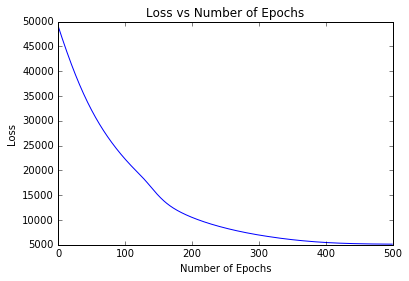

In [179]:
plot_loss(num_epochs, loss_results)

3.

K = 1
Final Loss:  38453.34375
% of points in each cluster:  {0: 100.0}


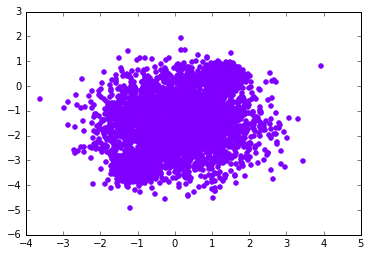

K = 2
Final Loss:  9203.76464844
% of points in each cluster:  {0: 50.51, 1: 49.49}


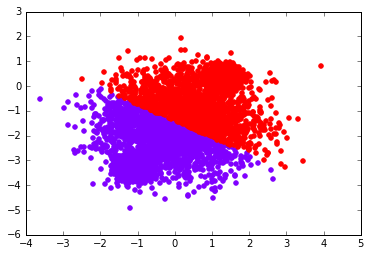

K = 3
Final Loss:  5178.10009766
% of points in each cluster:  {0: 37.88, 1: 23.4, 2: 38.72}


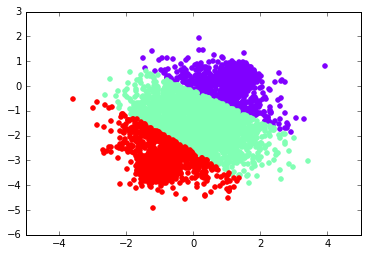

K = 4
Final Loss:  3389.66748047
% of points in each cluster:  {0: 12.01, 1: 37.34, 2: 37.25, 3: 13.4}


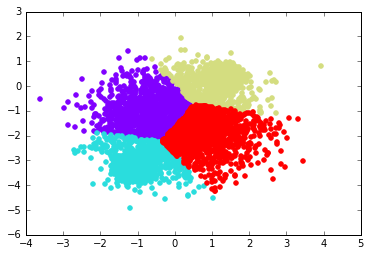

K = 5
Final Loss:  2932.72143555
% of points in each cluster:  {0: 37.37, 1: 37.0, 2: 7.34, 3: 11.72, 4: 6.57}


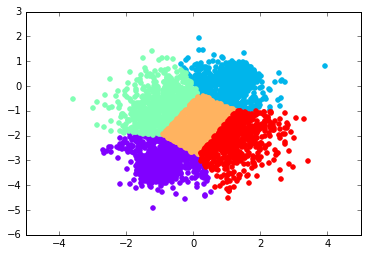

In [180]:
for k in range(1, 6):
    print 'K = {}'.format(k)
    
    loss_results, cluster_assg, _ = k_means(k, data, learning_rate, num_epochs, len(data))
    print 'Final Loss: ', loss_results.min()
    
    samples_per_cluster = dict(Counter(cluster_assg))
    samples_per_cluster.update((x, y * 100.0 / data.shape[0]) for x, y in samples_per_cluster.items())
    print '% of points in each cluster: ', samples_per_cluster
    
    plot_scatter(data, cluster_assg, k)

I would argue that 5 clusters is the best. It has the lowest loss, and best explains the variance of the data. The cluster centers are fairly representative of their assigned training points, and the distances between the centers of the different clusters are fairly significant. Using fewer clusters would mean that too much of the signal in the data is lost in the cluster prototypes. You can see from the plots that having 5 clusters helps to reduce the variance within each cluster, and forms natural-looking clumps from the data, rather than slices.

4.

In [182]:
validation_start = 2 * len(data) / 3
for k in range(1, 6):
    print 'K = {}'.format(k)
    
    loss_results, cluster_assg, validation_loss = k_means(k, data, learning_rate, num_epochs, validation_start)
    print 'Final Training Loss: ',   loss_results.min()
    print 'Final Validation Loss: ', validation_loss

K = 1
Final Training Loss:  25493.03125
Final Validation Loss:  12969.2
K = 2
Final Training Loss:  6139.40380859
Final Validation Loss:  3067.88
K = 3
Final Training Loss:  3427.63549805
Final Validation Loss:  1700.2
K = 4
Final Training Loss:  2298.76928711
Final Validation Loss:  1115.75
K = 5
Final Training Loss:  1948.23840332
Final Validation Loss:  956.653


I would again argue that 5 clusters is the best, as it has the lowest validation loss.

Note that the validation losses look larger than the training losses, as the training loss sums over twice as many datapoints.

### 2.1

1.

$P(z|x) = \frac{P(x, z)}{\sum_{z'=1}^{K}P(x, z')}$

 where $P(z) = \prod_{k=1}^{K}\pi_{k}^{z_k}$
 and $P(x|z) = \prod_{k=1}^{K}\mathcal{N}(x|\mu_k, \sigma_k^2)^{z_k}$

 so $P(x,z) = \prod_{k=1}^{K}[\pi_k\mathcal{N}(x|\mu_k, \sigma_k^2)]^{z_k}$

Therefore, $P(z|x) = \frac{\prod_{k=1}^{K}[\pi_k\mathcal{N}(x|\mu_k, \sigma_k^2)]^{z_k}}{\sum_{k=1}^{K}\pi_k\mathcal{N}(x|\mu_k, \sigma_k^2)}$

And $P(z=k|x) = \frac{\pi_k\mathcal{N}(x|\mu_k, \sigma_k^2)}{\sum_{k'=1}^{K}\pi_{k'}\mathcal{N}(x|\mu_{k'}, \sigma_{k'}^2)}$

2.

In [338]:
x_np = np.array([[1, 1], [2, 2]]).astype("float32")
mu_np = np.array([[1, 1], [2, 2], [3, 3]]).astype("float32")
var_np = np.array([[2, 2, 2]]).astype("float32")

In [339]:
X = tf.Variable(x_np)
mu = tf.Variable(mu_np)
var = tf.Variable(var_np)

In [216]:
def logGaussianPdf(X, mu, var):
    # We should have a D x D covariance matrix for each of the K
    # clusters. But each covariance matrix is a diagonal, and the
    # variance along the diagonal is the same for each cluster. So,
    # we can represent this with just a column vector of variances,
    # one for each cluster.
    #
    # X   is N X D
    # mu  is K x D
    # var is 1 x K

    assert X.get_shape()[1] == mu.get_shape()[1]
    assert mu.get_shape()[0] == var.get_shape()[1]
    
    dist = matDistance(X, mu) # N x K
    
    inv_var = 1 / var # 1 x K
    dist_inv_var = tf.mul(dist, inv_var) # N x K
    
    log_two_pi_variance = tf.log(2 * np.pi * var)  # 1 x K
    
    return -0.5 * (log_two_pi_variance + dist_inv_var) # N x K

In [263]:
log_prob = logGaussianPdf(X, mu, var)

init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    v = sess.run(log_prob)    
    print v # will show you your variable.

[[-1.26551211 -1.76551211 -3.26551199]
 [-1.76551211 -1.26551211 -1.76551211]]


In [264]:
np.exp(v)

array([[ 0.28209481,  0.17109914,  0.03817738],
       [ 0.17109914,  0.28209481,  0.17109914]], dtype=float32)

3.

It is possible to use tf.reduce_sum instead of the logsumexp function. you can compute the gaussian pdf instead of the log gaussian pdf, and then multiply it by the pi vector. Then you can use a reduce_sum across the rows, and take the logarithm of the resulting column. The advantage of using the log_sum_exp is to increase accuracy and try to avoid underflow/overflow issues with either very small or very large numbers in the linear domain, when using limited precision floating point numbers. Summing exponential functions (like the gaussian pdf) are extremely prone to numerical issues, even with relatively behaved inputs. The trick lies in subtracting the max from each data point, and adding it back later. This guarantees that all exponentials have a negative exponent, meaning the largest value you will exponentiate will be zero. Summing together numbers less than or equal to one will not result in overflow, and even if some numbers underflow, the result will still be reasonable.

In [340]:
pi_np = np.array([0.1, 0.3, 0.6]).astype('float32')

In [341]:
# What we expect, using numpy
pi_gaussian = np.exp(v) * pi_np
sum_pi_gaussian = pi_gaussian.sum(1)
prob_z_given_x = pi_gaussian / sum_pi_gaussian.reshape(-1, 1)
np.log(prob_z_given_x)

array([[-1.2896744 , -0.69106209, -1.49791479],
       [-2.48041034, -0.88179785, -0.68865085]], dtype=float32)

In [342]:
pi = tf.Variable(pi_np)

In [291]:
def logPiGaussian(X, mu, var, pi):
    # X   is N X D
    # mu  is K x D
    # var is 1 x K
    # pi  is 1 x K
    
    log_gaussian = logGaussianPdf(X, mu, var) # N x K
    log_pi = tf.log(pi) # 1 x K
    
    return log_pi + log_gaussian # N x K

In [292]:
def logProbZgivenX(X, mu, var, pi):
    # X   is N X D
    # mu  is K x D
    # var is 1 x K
    # pi  is 1 x K
    
    log_pi_gaussian = logPiGaussian(X, mu, var, pi) # N x K

    log_sum_pi_gaussian = tf.reshape(reduce_logsumexp(log_pi_gaussian, 1), [-1, 1]) # N x 1
    
    return log_pi_gaussian - log_sum_pi_gaussian # N x K
    

In [293]:
log_prob = logProbZgivenX(X, mu, var, pi)

init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    q = sess.run(log_prob)

In [294]:
print q

[[-1.28967428 -0.69106197 -1.49791479]
 [-2.4804101  -0.88179791 -0.68865073]]


### 2.2

1.

We make use of the chain rule, where $\nabla \log f(x) = \frac{\nabla f(x)}{f(x)}$

For the left side, we have $\nabla \log P(x) = \frac{\nabla P(x)}{P(x)}$

For the right side, we make use of Bayes rule, and the linearity of the gradient operator:
\begin{align*}
\sum_k P(z = k | x) \nabla \log P(x, z) \\ 
\sum_k P(z = k | x) \frac{\nabla P(x, z = k)}{P(x, z = k)} \\
\sum_k \frac{\nabla P(x, z = k)}{P(x)} \\
\frac{1}{P(x)} \sum_k \nabla P(x, z = k) \\
\frac{1}{P(x)} \nabla \sum_k P(x, z = k) \\
\frac{\nabla P(x)}{P(x)} \\
\end{align*}

2.

In [450]:
def variance_var(shape):
    initial = tf.truncated_normal(shape, mean=0, stddev=0.5) # Values between -1 and 1
    phi = tf.Variable(initial)
    return tf.exp(phi) # Values between 1/e and e

In [440]:
def pi_var(shape):
    psi = tf.Variable(tf.ones(shape))
    log_pi = logsoftmax(psi)
    return tf.exp(log_pi)

In [441]:
def negLogLikelihood(X, mu, var, pi):
    # X   is N X D
    # mu  is K x D
    # var is 1 x K
    # pi  is 1 x K
    
    log_pi_gaussian = logPiGaussian(X, mu, var, pi) # N x K
    log_sum_pi_gaussian = tf.reshape(reduce_logsumexp(log_pi_gaussian, 1), [-1, 1]) # N x 1
    
    sum_log_sum_pi_gaussian = tf.reduce_sum(log_sum_pi_gaussian, 0) # 1 x 1
    
    return -sum_log_sum_pi_gaussian # 1 x 1

In [540]:
def learn_mog(K, data, learning_rate, num_epochs, validation_start):
    
    training_data   = data[:validation_start]
    validation_data = data[validation_start:]
    
    N = training_data.shape[0]
    D = training_data.shape[1]
    
    X = tf.placeholder("float", shape=(None, D)) # N x D
    mu = mu_var((K, D), stddev=0.5) # K x D
    
    var = variance_var((1, K)) # 1 x K
    pi = pi_var((1, K)) # 1 x K
    
    L = negLogLikelihood(X, mu, var, pi)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(L)
    
    # Determine cluster assignments
    log_pi_gaussian = logPiGaussian(X, mu, var, pi) # N x K
    assg =  tf.argmax(log_pi_gaussian, 1)
    
    init = tf.initialize_all_variables()
    
    loss_results = np.zeros(num_epochs)
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            loss, _ = sess.run([L, train_op], feed_dict={X: training_data})
            loss_results[epoch] = loss
        
        cluster_assignments = sess.run(assg, feed_dict={X: training_data})
        _mu, _var, _pi      = sess.run([mu, var, pi])
        validation_loss     = sess.run(L, feed_dict={X: validation_data})
        
    return loss_results, validation_loss, cluster_assignments, _mu, _var, _pi

In [555]:
K = 3
learning_rate = 0.0000005
num_epochs = 500
validation_start = len(data)

In [556]:
loss_results, _, cluster_assignments, mu, var, pi = learn_mog(K, data, learning_rate, num_epochs, validation_start)

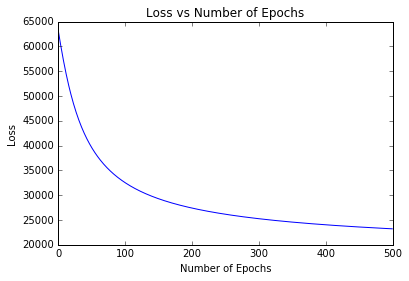

In [557]:
plot_loss(num_epochs, loss_results)

In [558]:
print 'Cluster means:\n', mu
print 'Cluster variances\n', var
print 'Cluster pi values\n', pi

Cluster means:
[[ 1.19485557  1.00073659]
 [-0.51722318 -0.67371082]
 [ 0.97087455  0.31565899]]
Cluster variances
[[ 1.28854239  4.25969982  0.39421073]]
Cluster pi values
[[ 0.21562459  0.54806638  0.23630911]]


3.

K = 1
Final Training Loss:  14125.0957031
Final Validation Loss:  [ 7126.74755859]
# of points in each cluster:  {0: 6666}


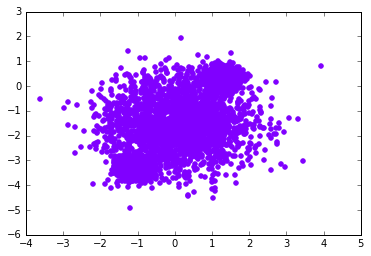

K = 2
Final Training Loss:  16463.1816406
Final Validation Loss:  [ 8380.25292969]
# of points in each cluster:  {0: 1248, 1: 5418}


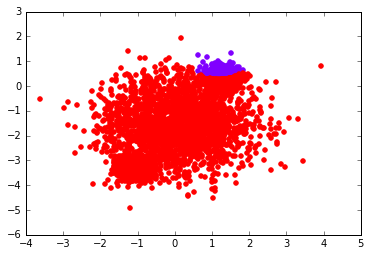

K = 3
Final Training Loss:  15577.984375
Final Validation Loss:  [ 7860.18603516]
# of points in each cluster:  {0: 4035, 1: 2626, 2: 5}


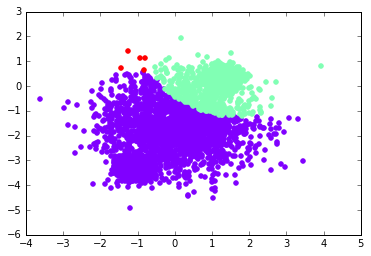

K = 4
Final Training Loss:  16379.4863281
Final Validation Loss:  [ 8330.66601562]
# of points in each cluster:  {0: 2443, 1: 4034, 2: 8, 3: 181}


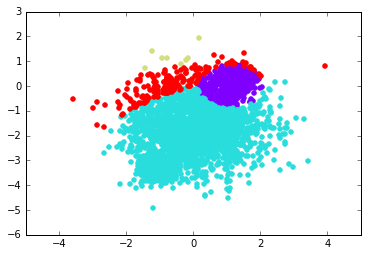

K = 5
Final Training Loss:  17172.0761719
Final Validation Loss:  [ 8738.60449219]
# of points in each cluster:  {0: 4872, 1: 82, 2: 1554, 3: 152, 4: 6}


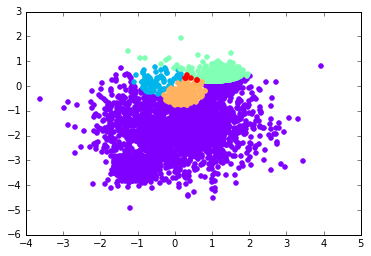

In [569]:
validation_start = 2 * len(data) / 3
for k in range(1, 6):
    print 'K = {}'.format(k)
    
    loss_results, validation_loss, cluster_assignments, mu, var, pi = learn_mog(k, data, learning_rate, num_epochs, validation_start)

    print 'Final Training Loss: ', loss_results[-1]
    print 'Final Validation Loss: ', validation_loss
    
    samples_per_cluster = dict(Counter(cluster_assignments))
    print '# of points in each cluster: ', samples_per_cluster
    
    plot_scatter(data, cluster_assignments, k)

From the above results, the validation loss is lowest with just one gaussian. This is somewhat plausible, as the data visually shows only one cluster. However, we expect results similar to K-means, where modelling the data with several clusters is best. The MOG algorithm is subject to random initializations of both the mean and variance, so this can have an effect on the convergence to a local minimum. This is why more sophisticated initialization procedures like K-means are typically used.

4.

In [572]:
large_data = np.load('data100D.npy')

In [675]:
large_data.shape

(10000, 100)

In [676]:
km_learning_rate = 0.01
km_num_epochs = 300

mog_learning_rate = 0.0000005
mog_num_epochs = 300

validation_start = 2 * len(large_data) / 3

In [681]:
for k in range(1, 11):
    print 'K = {}'.format(k)
    
    km_loss_results, _, km_validation_loss = k_means(k, large_data, km_learning_rate, km_num_epochs, validation_start)
    mog_loss_results, mog_validation_loss, _, _, _, _ = learn_mog(k, large_data, mog_learning_rate, mog_num_epochs, validation_start)
    
    print 'KM  Training   Loss: ', km_loss_results[-1]
    print 'MOG Training   Loss: ', mog_loss_results[-1]
    
    print 'KM  Validation Loss: ', km_validation_loss
    print 'MOG Validation Loss: ', mog_validation_loss[0]

K = 1
KM  Training   Loss:  667189.0
MOG Training   Loss:  28925.2363281
KM  Validation Loss:  333063.0
MOG Validation Loss:  14433.5
K = 2
KM  Training   Loss:  517522.65625
MOG Training   Loss:  31437.0644531
KM  Validation Loss:  258384.0
MOG Validation Loss:  15708.9
K = 3
KM  Training   Loss:  384820.40625
MOG Training   Loss:  33198.9570312
KM  Validation Loss:  191883.0
MOG Validation Loss:  16599.7
K = 4
KM  Training   Loss:  296806.75
MOG Training   Loss:  34147.3710938
KM  Validation Loss:  145989.0
MOG Validation Loss:  17061.9
K = 5
KM  Training   Loss:  249639.140625
MOG Training   Loss:  35257.84375
KM  Validation Loss:  127588.0
MOG Validation Loss:  17613.3
K = 6
KM  Training   Loss:  250961.0625
MOG Training   Loss:  35867.1679688
KM  Validation Loss:  126580.0
MOG Validation Loss:  17913.2
K = 7
KM  Training   Loss:  152817.0625
MOG Training   Loss:  36994.03125
KM  Validation Loss:  76320.3
MOG Validation Loss:  18488.0
K = 8
KM  Training   Loss:  149516.890625
MOG T

The validation error for the MOG model increases slowly with the number of clusters, while the validation error for the K-means model decreases quickly with the number of clusters. The validation loss for the K-means model is a minimum when K = 9, so I would argue that there are 9 clusters in the data. With fewer clusters, the MOG model is able to fit the data much better than K-means, as the large distance from cluster centers can be scled down by a large variance. 